# DBTL1: Filter recommendations
In `DBTL3_B_art_modeling_and_recommend.ipynb` we generated ART predictions of all possible combinations of up to 4 different CRISPRi gRNAs. 

Here, we will define a filtering strategy for the recommendations and use it to generate recommendations for DBTL4.

We import all recommendations, and then define a 

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../'
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
import warning_utils
warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import resource
# Convert 4GB to bytes
memory_limit = 16 * 1024 * 1024 * 1024

# Set the memory limit
resource.setrlimit(resource.RLIMIT_DATA, (memory_limit, memory_limit))

In [4]:
fig_loc = './dbtl5_figures_and_analysis/'
art_path = 'dbtl5_art_outputs/art.cpkl'
rec_df = pd.read_pickle('./dbtl5_figures_and_analysis/dbtl5_rec_df_filtered_training_data.pkl')
data_df = pd.read_pickle(f'./dbtl5_figures_and_analysis/dbtl3_dbtl4_dbtl5_isoprenol_processed_df.pkl')


## 1 Import `rec_df`, `data_df`, and trained ART model.

Import recommendation dataframe

In [5]:
# rec_df = pd.read_pickle('./dbtl3_figures_and_analysis/dbtl0_dbtl1_dbtl3_rec_df_filtered_training_data.pkl')
# rec_df = pd.read_pickle('./dbtl3ONLY_figures_and_analysis/dbtl3_rec_df_filtered_training_data.pkl')

Dataframe of training data

In [6]:
# data_df = pd.read_pickle(f'./dbtl3ONLY_figures_and_analysis/dbtl0_dbtl1_dbtl3_isoprenol_processed_df.pkl')
# data_df = pd.read_pickle(f'./dbtl3ONLY_figures_and_analysis/dbtl0_dbtl1_dbtl3_isoprenol_processed_df.pkl')

Sort `rec_df` and take a small subset from the top of the dataframe.

In [7]:
# rec_df = rec_df.sort_values(by = 'pp_mean', ascending = False).iloc[:500000,:]
rec_df = rec_df.sort_values(by = 'pp_mean', ascending = False)

Get the columns related to gRNA (perturbations) from the recs.

In [8]:
pert_columns = rec_df.columns[:-2]

In [9]:
data_df.head(3)

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
789,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,mg/L,473.4303,1,PP_0528_PP_0813_PP_0815_PP_1317,None,3,False,"[PP_0528, PP_0813, PP_0815, PP_1317]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_0815_PP_1317-R1
790,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,mg/L,325.8933,1,PP_0528_PP_0813_PP_4191,None,3,False,"[PP_0528, PP_0813, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_4191-R1
791,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,mg/L,372.1794,1,PP_0528_PP_0814_PP_4191,None,3,False,"[PP_0528, PP_0814, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0814_PP_4191-R1


In [10]:
# dbtl2_data_df['line_name_norep'] = dbtl2_data_df['Line Name'].apply(lambda x: x[:-3])
# dbtl2_data_df

### 1.1 Add information to `rec_df`
Since we generated recs for all possible combinations of gRNA, some of the recs are in the experimental data. It would be useful to check if recommendations are in the experimental data or not.

First, add a `number_of_grna` column to recommendations to make them easier to filter.

In [11]:
rec_df['number_of_grna'] = rec_df.loc[:, pert_columns].apply(sum, axis = 1).astype(int)

Add indicator column to `rec_df`

In [12]:
rec_df['in_expt'] = False

Iterate through rows of experimental data (since there is less of it)

In [13]:
for idx, expt_row in data_df.iterrows():
    n_grna_expt = expt_row['number_of_grna']
    rec_df_subset = rec_df[rec_df['number_of_grna']==n_grna_expt]
    
    matching_subset_index = (
        (np.all(rec_df.loc[:, pert_columns] == expt_row[pert_columns], axis = 1)) & 
        (rec_df.loc[:, 'number_of_grna'] == n_grna_expt)
    )
    assert sum(matching_subset_index)==1, f'ERROR: experimental data missing from recommendations {expt_row["Line Name"]}'
    rec_df_index = rec_df_subset.loc[matching_subset_index,:].index
    rec_df.loc[rec_df_index, 'in_expt'] = True

In [14]:
rec_df_already_made = rec_df.copy()

In [15]:
rec_df_already_made.head(3)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt
64241,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,658.569309,83.455782,4,False
64188,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,644.236069,74.957160,4,False
64095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,643.648856,74.780261,4,True


In [16]:
rec_df = rec_df[rec_df['in_expt'] == 0]

In [17]:
rec_df[rec_df['in_expt'] == 1]['number_of_grna'].value_counts()

Series([], Name: count, dtype: int64)

In [18]:
data_df.loc[data_df['cycle']==3,:]

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
789,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,mg/L,473.4303,1,PP_0528_PP_0813_PP_0815_PP_1317,None,3,False,"[PP_0528, PP_0813, PP_0815, PP_1317]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_0815_PP_1317-R1
790,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,mg/L,325.8933,1,PP_0528_PP_0813_PP_4191,None,3,False,"[PP_0528, PP_0813, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0813_PP_4191-R1
791,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,mg/L,372.1794,1,PP_0528_PP_0814_PP_4191,None,3,False,"[PP_0528, PP_0814, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0814_PP_4191-R1
792,PP_0528_PP_0751_PP_4191-R1,DBTL3_P1_004,mg/L,400.7445,1,PP_0528_PP_0751_PP_4191,None,3,False,"[PP_0528, PP_0751, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0751_PP_4191-R1
793,PP_0528_PP_0815_PP_4191-R1,DBTL3_P1_005,mg/L,398.0633,1,PP_0528_PP_0815_PP_4191,None,3,False,"[PP_0528, PP_0815, PP_4191]",...,0,0,0,0,0,0,True,False,1,PP_0528_PP_0815_PP_4191-R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,PP_0815_PP_1317-R3,DBTL3_P4_041,mg/L,380.1841,3,PP_0815_PP_1317,None,3,False,"[PP_0815, PP_1317]",...,0,0,0,0,0,0,True,True,3,PP_0815_PP_1317-R3
968,PP_0528_PP_0815_PP_1317_P4-R3,DBTL3_P4_042,mg/L,387.5350,3,PP_0528_PP_0815_PP_1317_P4,None,3,False,"[PP_0528, PP_0815, PP_1317]",...,0,0,0,0,0,0,True,False,3,PP_0528_PP_0815_PP_1317_P4-R3
969,PP_0812_PP_1769-R3,DBTL3_P4_043,mg/L,364.8823,3,PP_0812_PP_1769,None,3,False,"[PP_0812, PP_1769]",...,0,0,0,0,0,0,True,False,3,PP_0812_PP_1769-R3
970,PP_0368_PP_4189_P4-R3,DBTL3_P4_044,mg/L,240.6646,3,PP_0368_PP_4189_P4,None,3,False,"[PP_0368, PP_4189]",...,0,0,0,0,0,0,True,False,3,PP_0368_PP_4189_P4-R3


In [19]:
rec_df_already_made.sort_values('pp_mean', ascending = False).head(20)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt
64241,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,658.569309,83.455782,4,False
64188,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,644.236069,74.957160,4,False
64095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,643.648856,74.780261,4,True
60172,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,640.245871,76.839936,4,False
3598,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,638.810720,74.749286,3,True
66545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,633.843115,81.926298,4,False
68655,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,632.319597,74.842403,4,False
61688,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,632.319597,74.842403,4,False
68654,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,632.319597,74.842403,4,False
68674,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,632.319597,74.842403,4,False


In [20]:
data_df[data_df['has_cycle1_gene']]['number_of_grna'].value_counts()

number_of_grna
3    240
2    228
4     42
1      6
Name: count, dtype: int64

### 1.X Remove recs with non DBTL3 gRNA in them

In [21]:
data_df['sorted_gene_list']
all_dbtl34_genes = list(
    np.unique(
        np.array(
            [
                g for gl in data_df['sorted_gene_list']
                for g in gl
            ]
        )
    )
)
all_gene_columns = rec_df.columns[:-4]
non_dbtl34_columns = [gene_column for gene_column in all_gene_columns if gene_column not in all_dbtl34_genes]


print(f'There are N = {len(all_gene_columns)} total columns, N = {len(all_dbtl34_genes)} are in dbtl3 and N = {len(non_dbtl34_columns)} not in dbtl3')
assert len(non_dbtl34_columns) + len(all_dbtl34_genes) == len(all_gene_columns)

There are N = 57 total columns, N = 16 are in dbtl3 and N = 41 not in dbtl3


In [22]:
rec_df['non_dbtl34_gene'] = np.any(rec_df.loc[:, non_dbtl34_columns], axis = 1)

In [23]:
rec_df.loc[~rec_df['non_dbtl34_gene'], 'number_of_grna'].value_counts()

number_of_grna
4    1806
3     483
2      45
1      14
Name: count, dtype: int64

In [24]:
rec_df = rec_df.loc[~rec_df['non_dbtl34_gene']]

In [25]:
rec_df_already_made['non_dbtl34_gene'] = np.any(rec_df_already_made.loc[:, non_dbtl34_columns], axis = 1)

In [26]:
rec_df_already_made = rec_df_already_made[~rec_df_already_made['non_dbtl34_gene']]

In [27]:
rec_df_already_made[rec_df_already_made['number_of_grna'] == 4].sort_values('pp_mean', ascending = False).head(20)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene
64241,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,658.569309,83.455782,4,False,False
64188,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,644.236069,74.957160,4,False,False
64095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,643.648856,74.780261,4,True,False
60172,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,640.245871,76.839936,4,False,False
66545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,633.843115,81.926298,4,False,False
68664,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,632.319597,74.842403,4,False,False
64142,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,630.334901,74.955062,4,False,False
112474,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,628.814330,76.130274,4,False,False
64244,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,625.247458,74.980179,4,False,False
178384,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,624.803525,75.206270,4,False,False


In [28]:
STRAIN_OF_INTEREST = 'PP_0368_PP_0751_PP_0815'

In [29]:
rec_df_subset = rec_df_already_made.loc[
    (rec_df_already_made['PP_0368'] == 1) & 
    (rec_df_already_made['PP_0751'] == 1) &
    (rec_df_already_made['PP_0815'] == 1)
    ,
    :
]

In [30]:
write_line_name = lambda x: '_'.join(pert_columns[np.where(x[pert_columns] == 1)])


In [31]:
rec_df_subset['line_name'] = rec_df_subset.apply(write_line_name, axis = 1)
pert_column_subset = pd.Index([pert for pert in pert_columns if pert not in ['PP_0368', 'PP_0751', 'PP_0815']])
write_line_name_subset = lambda x: '_'.join(pert_column_subset[np.where(x[pert_column_subset] == 1)])
rec_df_subset['added_grna'] = rec_df_subset.apply(write_line_name_subset, axis = 1)
rec_df_subset

/tmp/ipykernel_2291/2455830597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_df_subset['line_name'] = rec_df_subset.apply(write_line_name, axis = 1)
/tmp/ipykernel_2291/2455830597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_df_subset['added_grna'] = rec_df_subset.apply(write_line_name_subset, axis = 1)


,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,line_name,added_grna
64241,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,658.569309,83.455782,4,False,False,PP_0368_PP_0751_PP_0815_PP_1506,PP_1506
64188,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,644.236069,74.957160,4,False,False,PP_0368_PP_0751_PP_0814_PP_0815,PP_0814
64095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,643.648856,74.780261,4,True,False,PP_0368_PP_0751_PP_0812_PP_0815,PP_0812
60172,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,640.245871,76.839936,4,False,False,PP_0368_PP_0528_PP_0751_PP_0815,PP_0528
3408,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,631.823918,74.946161,3,True,False,PP_0368_PP_0751_PP_0815,
64142,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,630.334901,74.955062,4,False,False,PP_0368_PP_0751_PP_0813_PP_0815,PP_0813
64244,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,625.247458,74.980179,4,False,False,PP_0368_PP_0751_PP_0815_PP_1769,PP_1769
64260,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,614.354265,81.278525,4,False,False,PP_0368_PP_0751_PP_0815_PP_4120,PP_4120
64247,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,584.024198,75.431401,4,False,False,PP_0368_PP_0751_PP_0815_PP_2136,PP_2136
64268,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,575.507212,78.494050,4,False,False,PP_0368_PP_0751_PP_0815_PP_4192,PP_4192


Text(0.5, 0, 'Predicted titer after adding gRNA')

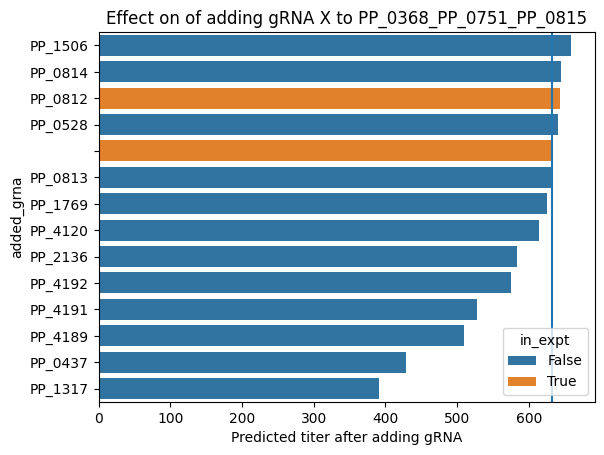

In [32]:
fig, ax = plt.subplots()
sns.barplot(data = rec_df_subset, y = 'added_grna', x = 'pp_mean', hue = 'in_expt')
ax.axvline(rec_df_subset.loc[rec_df_subset['number_of_grna'] == 3, 'pp_mean'].values[0])
ax.set_title(f'Effect on of adding gRNA X to {STRAIN_OF_INTEREST}')
ax.set_xlabel('Predicted titer after adding gRNA')

In [33]:
write_line_name = lambda x: '_'.join(pert_columns[np.where(x == 1)])

## 2. Filter recs and save final recs for DBTL3
Define the following variables:

- `N_total_recs`: The total number of recommendations.
- `N_grna_dict`: A dictionary defining how many recommendations of each length are requrested. Entries are formatted as {number of gRNA: number of recs}. 
- `max_grna_appearances`: A number controlling how many times a single guide RNA can show up in the recommendations.

Create an indicator column for whether a candidate recommendation should be kept.

In [34]:
rec_df['to_rec'] = 0

### 2.1 Define functions to identify recommendations
We will iterate through `rec_df` and selectively identify candidate recommendations to keep.

In [35]:
write_line_name = lambda x: '_'.join(pert_columns[np.where(x == 1)])

In [36]:
n_total_recs = 60
n_grna_dict = {0: 0,
               1: 0,
               2: 10,
               3: 30,
               4: 20,
               5: 0}

assert sum(n_grna_dict.values()) == n_total_recs, "Number of total recs should equal the num of N_gRNA in N_grna_dict"

max_grna_appearances = 25
# max_grna_appearances_per_ngrna = 15
max_grna_appearances_per_ngrna = 200

Create variables to track how many of each gRNA length we've added, and how many of each gRNA.

Then, iterate through rec_df. At each iteration:

1. Get the number of gRNA and the gRNA identities of the current candidate.
2. Check how many recommendations already have the number of gRNA and gRNA identities of current candidate.
3. If the current recommendation is allowed (doesn't exceed the number of gRNA lengths or gRNA appearances), change `rec_df['to_rec']` to 1.

End loop once the required number of reqs (`n_total_recs`) is reached.

In [37]:
grna_len_tracker = {0: 0,
                    1: 0,
                    2: 0,
                    3: 0,
                    4: 0,
                    5: 0}
grna_tracker = dict(zip(pert_columns.values, [0 for i in range(len(pert_columns))]))
grna_tracker_by_length = pd.DataFrame(index = n_grna_dict.keys(), columns = pert_columns, data = 0)
n_recs_added = 0
n_recs_skipped = 0
rec_list = []
for rec_idx, rec_data in rec_df.iterrows():
    #Get values to check whether to keep this rec
    current_grna_length = rec_data['number_of_grna']
    current_grna = pert_columns[np.where(rec_data[pert_columns] == 1)].values

    #Get values from trackers for recommendations and recommendation lengths
    # already_recommended_grna = np.array([grna_tracker[grna] for grna in current_grna])
    already_recommended_grna = grna_tracker_by_length.loc[current_grna_length, current_grna].values
    already_recommended_lengths = grna_len_tracker[current_grna_length]
    
    # print(f'Already recommended grna: {already_recommended_grna}\t already recommended lengths: {already_recommended_lengths}')
    
    if np.any(already_recommended_grna>=max_grna_appearances_per_ngrna) or already_recommended_lengths>=n_grna_dict[current_grna_length]:
        n_recs_skipped += 1
    else:
        print(f'\nadding rec: {rec_idx}')
        print(f'Rec Idx: {rec_idx}\tCurrent grna: {current_grna}\tCurrent grna length: {current_grna_length}')
        print(f'Already recommended grna: {already_recommended_grna}\t already recommended lengths: {already_recommended_lengths}')

        rec_df.loc[rec_idx, 'to_rec'] = 1
        grna_len_tracker[current_grna_length] += 1
        for current_single_grna in current_grna:
            grna_tracker[current_single_grna] += 1
            grna_tracker_by_length.loc[current_grna_length, current_single_grna] += 1
        n_recs_added+=1
        rec_list.append(list(current_grna))
        # print(rec_list)
        # print('\n')
    if n_recs_added >= n_total_recs:
        print('Number of total recs reached, breaking')
        print('~~~~~~~~~~~~~~~~~~~~~')
        break
    # if n_recs_added>20:
    #     break
print(f'Number of skipped candidates: {n_recs_skipped}\t Number of added candidates: {n_recs_added}')


adding rec: 64241
Rec Idx: 64241	Current grna: ['PP_0368' 'PP_0751' 'PP_0815' 'PP_1506']	Current grna length: 4
Already recommended grna: [0 0 0 0]	 already recommended lengths: 0

adding rec: 64188
Rec Idx: 64188	Current grna: ['PP_0368' 'PP_0751' 'PP_0814' 'PP_0815']	Current grna length: 4
Already recommended grna: [1 1 0 1]	 already recommended lengths: 1

adding rec: 60172
Rec Idx: 60172	Current grna: ['PP_0368' 'PP_0528' 'PP_0751' 'PP_0815']	Current grna length: 4
Already recommended grna: [2 0 2 2]	 already recommended lengths: 2

adding rec: 66545
Rec Idx: 66545	Current grna: ['PP_0368' 'PP_0812' 'PP_0815' 'PP_1506']	Current grna length: 4
Already recommended grna: [3 0 3 1]	 already recommended lengths: 3

adding rec: 68664
Rec Idx: 68664	Current grna: ['PP_0368' 'PP_0814' 'PP_0815' 'PP_1769']	Current grna length: 4
Already recommended grna: [4 1 4 0]	 already recommended lengths: 4

adding rec: 6217
Rec Idx: 6217	Current grna: ['PP_0528' 'PP_0751' 'PP_0815']	Current grna leng

In [38]:
grna_tracker_by_length

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4266,PP_4549,PP_4550,PP_4651,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,3,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,5,0,5,0,0,8,0,3,5,...,0,0,0,0,0,0,0,0,0,0
4,0,11,0,4,0,0,14,0,5,6,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
rec_df['to_rec'].sum()

60

In [40]:
n_total_recs

60

In [41]:
# assert rec_df['to_rec'].sum() == n_total_recs, 'ERROR: incorrect number of recommendations'

### 2.2 Create dataframe for filtered recs

In [42]:
filtered_recs = rec_df[rec_df['to_rec'] == 1].copy()

In [43]:
filtered_recs = filtered_recs.sort_values('pp_mean', ascending=False)

Add human-readable line name to recs_df

In [44]:
filtered_recs['line_name'] = filtered_recs.loc[:,pert_columns].apply(write_line_name, axis = 1)

In [45]:
filtered_recs.head(5)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,to_rec,line_name
64241,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,658.569309,83.455782,4,False,False,1,PP_0368_PP_0751_PP_0815_PP_1506
64188,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,644.236069,74.957160,4,False,False,1,PP_0368_PP_0751_PP_0814_PP_0815
60172,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,640.245871,76.839936,4,False,False,1,PP_0368_PP_0528_PP_0751_PP_0815
66545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,633.843115,81.926298,4,False,False,1,PP_0368_PP_0812_PP_0815_PP_1506
68664,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,632.319597,74.842403,4,False,False,1,PP_0368_PP_0814_PP_0815_PP_1769


### 2.3 Cross-reference recs against ART0/1/2

In [46]:
# art012_rec_df = pd.read_pickle('./dbtl2_figures_and_analysis/dbtl0_dbtl1_dbtl2_rec_df_filtered_training_data.pkl')
# art012_path = './dbtl2_art_outputs/art.cpkl'
# with open(art012_path, 'rb') as art_file:
#     art012 = cloudpickle.load(art_file)

In [47]:
# filtered_recs.loc[:,'art012_pp_mean'] = np.nan
# filtered_recs.loc[:,'art012_pp_std'] = np.nan


# for idx, filtered_rec in filtered_recs.iterrows():
#     split_targets = np.sort(re.findall('PP_[0-9]{4}', filtered_rec['line_name']))
#     num_grna = filtered_rec['number_of_grna']
    
#     art012_rec_idx = (
#         (
#             np.all(
#                 np.stack(
#                     [np.array(art012_rec_df[target_column] == 1) for target_column in split_targets]
#                 ), 
#                 axis = 0)
#         ) &
#         (art012_rec_df.loc[:, pert_columns].sum(axis = 1) == num_grna)
#     )
#     assert sum(art012_rec_idx) == 1
#     filtered_recs.loc[idx, ['art012_pp_mean', 'art012_pp_std']] = art012_rec_df.loc[art012_rec_idx, ['pp_mean', 'pp_std']].values    

In [48]:
# filtered_recs

#### Filter out ART0/1/2 bad strains

In [49]:
# art012_threshold = 300
# delta_pred_threshold = 50

In [50]:
# filtered_recs['art012_drop'] = (
#     (filtered_recs['art012_pp_mean']<300) &
#     (filtered_recs['pp_mean'] - filtered_recs['art012_pp_mean'] > 50)
# )


In [51]:
# fig, ax = plt.subplots()
# sns.scatterplot(data = filtered_recs, x = 'pp_mean', y = 'art012_pp_mean', hue = 'art012_drop', ax = ax)
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]

# # now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.axline((300,300), slope=1, color='black')
# ax.set_xlabel('ART3/4 predicted mean')
# ax.set_ylabel('ART0/1/2 predicted mean')

In [52]:
# filtered_recs = filtered_recs.loc[~filtered_recs['art012_drop'],:]

### Get final recs from filtered rec list
Get the top N recs from the filtered set

In [53]:
# filtered_recs

In [54]:
# n_grna_dict = {
#     2: 25,
#     3: 30,
#     4: 5
# }
# top_n_recs = []

# for n_grna in n_grna_dict.keys():
#     print(n_grna)
#     top_n_recs.append(
#         filtered_recs.loc[filtered_recs['number_of_grna'] == n_grna, :].sort_values('pp_mean', ascending = False).head(n_grna_dict[n_grna])
#     )
# filtered_recs = pd.concat(top_n_recs)
# filtered_recs.head(5)

In [55]:
# filtered_recs = filtered_recs.drop(columns=['art012_pp_mean', 'art012_pp_std', 'art012_drop']).sort_values('pp_mean', ascending = False).reset_index(drop = True)

In [56]:
# filtered_recs

### 2.3 Plot gRNA identities and distributions for each recommendation

Import trained ART model:

In [57]:
with open(art_path, 'rb') as art_file:
    art = cloudpickle.load(art_file)

Define function to plot distributions

In [58]:
def plot_draws(preds, feature_columns, prev_max = None, title_text = None, figsize = (6,6)):
    
    fig, ax = plt.subplots(figsize = figsize)
    draws = art.post_pred_draws(preds.loc[:,feature_columns], n_samples = 1000)[0]
    draws_df = pd.DataFrame(data = draws, columns = preds['line_name'])
    draws_df = pd.melt(draws_df, value_vars= preds['line_name'], value_name = 'titer', var_name = 'Line Name')

    pal = sns.cubehelix_palette(10, rot=-0.45, start=0.0, dark=0.3, light=0.7, reverse=True)
    sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)
    if prev_max is not None:
        ax.axvline(prev_max, color = 'k', linestyle = '--', linewidth = 0.5)
    if title_text is not None:
        ax.set_title(title_text)    
    return fig

Sampling: [y]
/tmp/ipykernel_2291/271477315.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)
/tmp/ipykernel_2291/271477315.py:9: UserWarning: 
The palette list has fewer values (10) than needed (60) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)
Sampling: [y]
/tmp/ipykernel_2291/271477315.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)


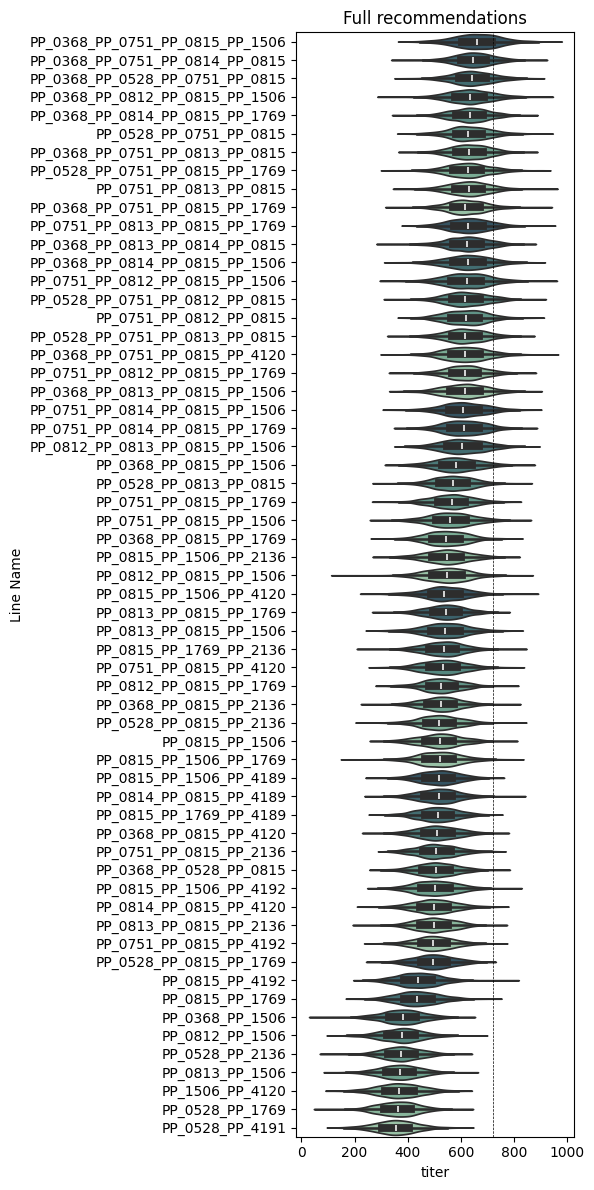

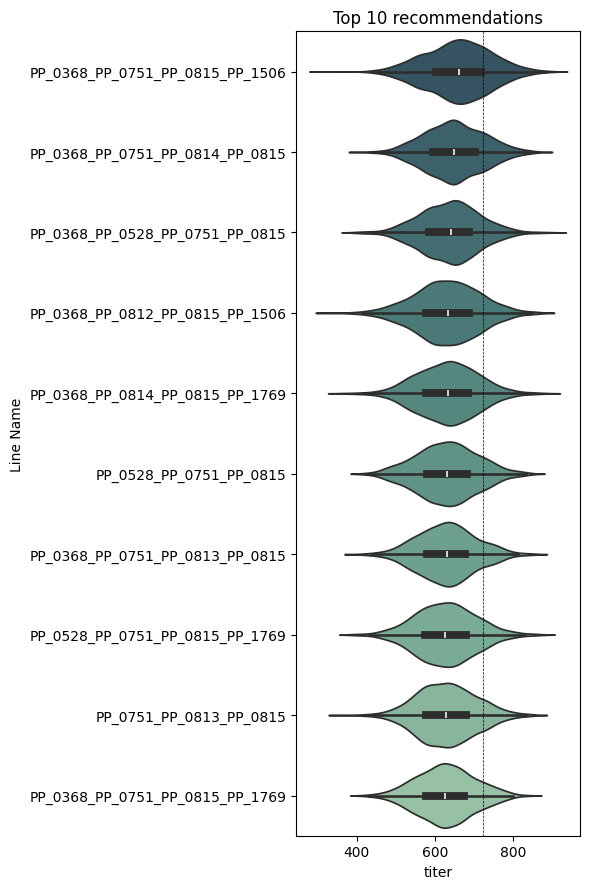

In [59]:
fig = plot_draws(filtered_recs,
                 feature_columns=pert_columns,
                 prev_max = data_df['isoprenol'].max(),
                 title_text = 'Full recommendations',
                 figsize = (6, 12))
fig.tight_layout()

fig.savefig(fig_loc + '/filtered_recs_draws_allrecs.png')

fig = plot_draws(filtered_recs.iloc[:10,:], 
                 feature_columns=pert_columns,
                 prev_max = data_df['isoprenol'].max(),
                 title_text = 'Top 10 recommendations',
                 figsize = (6, 9))
fig.tight_layout()

fig.savefig(fig_loc + '/filtered_recs_draws_top10recs.png')


In [60]:
grna_count = np.sum(filtered_recs.loc[:, pert_columns], axis = 0)
grna_count_df = pd.DataFrame(data = grna_count)
grna_count_df = grna_count_df.reset_index()
grna_count_df=grna_count_df.rename(columns={grna_count_df.columns.values[1]:'counts', 'index':'grna'})


Plot and format the counts datafame

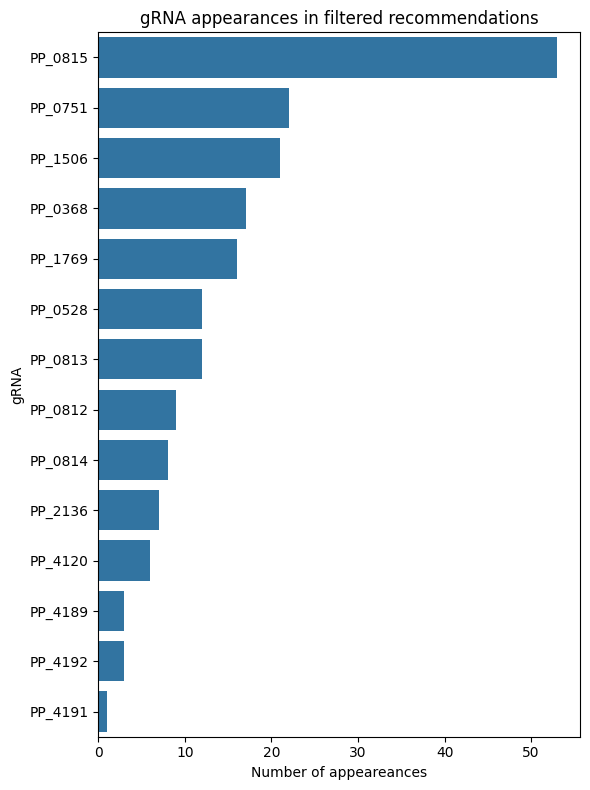

In [61]:
fig, ax = plt.subplots(figsize = (6,8))
sns.barplot(grna_count_df[grna_count_df['counts'] >0].sort_values(by = 'counts', ascending = False), x = 'counts', y = 'grna', ax = ax)
ax.set_title(f'gRNA appearances in filtered recommendations')
ax.set_xlabel('Number of appeareances')
ax.set_ylabel('gRNA')
fig.tight_layout()
fig.savefig(f'{fig_loc}gRNA_appearances_in_filtered_recs.png')

### 2.4 Save final recommendation as a dataframe

In [62]:
filtered_recs_export = filtered_recs.drop(columns=pert_columns)

In [63]:
filtered_recs

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,non_dbtl34_gene,to_rec,line_name
64241,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,658.569309,83.455782,4,False,False,1,PP_0368_PP_0751_PP_0815_PP_1506
64188,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,644.236069,74.957160,4,False,False,1,PP_0368_PP_0751_PP_0814_PP_0815
60172,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,640.245871,76.839936,4,False,False,1,PP_0368_PP_0528_PP_0751_PP_0815
66545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,633.843115,81.926298,4,False,False,1,PP_0368_PP_0812_PP_0815_PP_1506
68664,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,632.319597,74.842403,4,False,False,1,PP_0368_PP_0814_PP_0815_PP_1769
6217,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,631.673506,75.858736,3,False,False,1,PP_0528_PP_0751_PP_0815
64142,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,630.334901,74.955062,4,False,False,1,PP_0368_PP_0751_PP_0813_PP_0815
112474,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,628.814330,76.130274,4,False,False,1,PP_0528_PP_0751_PP_0815_PP_1769
10187,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,628.444038,75.023558,3,False,False,1,PP_0751_PP_0813_PP_0815
64244,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,625.247458,74.980179,4,False,False,1,PP_0368_PP_0751_PP_0815_PP_1769


In [64]:
filtered_recs_export
column_reorder = ['line_name', 'pp_mean', 'pp_std', 'number_of_grna', 'in_expt', 'to_rec']
filtered_recs_export = filtered_recs_export[column_reorder]
filtered_recs_export

,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
64241,PP_0368_PP_0751_PP_0815_PP_1506,658.569309,83.455782,4,False,1
64188,PP_0368_PP_0751_PP_0814_PP_0815,644.236069,74.957160,4,False,1
60172,PP_0368_PP_0528_PP_0751_PP_0815,640.245871,76.839936,4,False,1
66545,PP_0368_PP_0812_PP_0815_PP_1506,633.843115,81.926298,4,False,1
68664,PP_0368_PP_0814_PP_0815_PP_1769,632.319597,74.842403,4,False,1
6217,PP_0528_PP_0751_PP_0815,631.673506,75.858736,3,False,1
64142,PP_0368_PP_0751_PP_0813_PP_0815,630.334901,74.955062,4,False,1
112474,PP_0528_PP_0751_PP_0815_PP_1769,628.814330,76.130274,4,False,1
10187,PP_0751_PP_0813_PP_0815,628.444038,75.023558,3,False,1
64244,PP_0368_PP_0751_PP_0815_PP_1769,625.247458,74.980179,4,False,1


In [65]:
filtered_recs_export.to_csv(fig_loc + 'filtered_recs_for_dbtl6.csv')